## An OMOP Cohort: Patients Exposed to Amiodarone Hydrochloride > 30 Days

### Part V: Time Series Analysis - Post-Exposure Visits

An examination of de-identified longitudinal visit and procedure data (derived to OMOP from Medicare DeSYNPuf data, 2008-2010, by OHDSI) and associated ICD9CM diagnosis codes to analyze the incidence and prevalence of AEs associated with amiodarone toxicity to the lung, thyroid and liver.

Kyle P. Rasku MS BSN RN

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np

In [2]:
cv_df = pd.read_csv("condition_visits_for_ts.csv", parse_dates=["vstart"]).drop(["Unnamed: 0"], axis=1, errors="ignore")

In [3]:
cv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5617 entries, 0 to 5616
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   treatment_start          5617 non-null   object        
 1   treatment_period         5617 non-null   float64       
 2   treatment_end            5617 non-null   object        
 3   visit_id                 5617 non-null   int64         
 4   vstart                   5617 non-null   datetime64[ns]
 5   vprovider                5608 non-null   float64       
 6   care_site                5612 non-null   float64       
 7   diagnosis_1              5617 non-null   object        
 8   diagnosis_2              4279 non-null   object        
 9   diagnosis_3              2137 non-null   object        
 10  diagnosis_4              1033 non-null   object        
 11  diagnosis_5              443 non-null    object        
 12  diagnosis_6              187 non-n

In [4]:
cv_agg = cv_df.groupby(["vstart"]).agg({'treatment_period': 'mean', 'visit_id': 'count',
                                                                            'vprovider': 'count',
                                                                            'care_site': 'count',
                                                                            'diagnosis_1' : 'count',
                                                                            'diagnosis_2' : 'count',
                                                                            'diagnosis_3' : 'count',
                                                                            'diagnosis_4' : 'count',
                                                                            'diagnosis_5' : 'count',
                                                                            'diagnosis_6' : 'count',
                                                                            'diagnosis_7' : 'count',
                                                                            'diagnosis_8' : 'count',
                                                                            'diagnosis_9' : 'count',
                                                                            'diagnosis_10' : 'count',
                                                                            'diagnosis_11' : 'count',
                                                                            'pdesc_1' : 'count',
                                                                            'pdesc_2' : 'count',
                                                                            'pdesc_3' : 'count',
                                                                            'pdesc_4' : 'count',
                                                                            'pdesc_5' : 'count',
                                                                            'pdesc_6' : 'count',
                                                                            'pdesc_7' : 'count',
                                                                            'pdesc_8' : 'count',
                                                                            'pdesc_9' : 'count',
                                                                            'pdesc_10' : 'count',
                                                                            'pdesc_11' : 'count',
                                                                            'pdesc_12' : 'count',
                                                                            'pdesc_13' : 'count',
                                                                            'pdesc_14' : 'count',
                                                                            'pdesc_15' : 'count',
                                                                            'pdesc_16' : 'count',
                                                                            'sentinel_condition_code': 'count',
                                                                            'sentinel_condition_type': 'count'
                                                                           })

In [5]:
cv_agg["visit_diagnoses"] = cv_agg["diagnosis_1"] + cv_agg["diagnosis_2"] + cv_agg["diagnosis_3"] + cv_agg["diagnosis_4"] + cv_agg["diagnosis_5"] +  cv_agg["diagnosis_6"] + cv_agg["diagnosis_7"] + cv_agg["diagnosis_8"] + cv_agg["diagnosis_9"] + cv_agg["diagnosis_10"] + cv_agg["diagnosis_11"] 
cv_agg["visit_procedures"] = cv_agg["pdesc_1"] + cv_agg["pdesc_2"] + cv_agg["pdesc_3"] + cv_agg["pdesc_4"] + cv_agg["pdesc_5"] +  cv_agg["pdesc_6"] + cv_agg["pdesc_7"] + cv_agg["pdesc_8"] + cv_agg["pdesc_9"] + cv_agg["pdesc_10"] + cv_agg["pdesc_11"]  + cv_agg["pdesc_12"]  + cv_agg["pdesc_13"] + cv_agg["pdesc_14"]  + cv_agg["pdesc_15"]  + cv_agg["pdesc_16"] 
cv_agg["sentinel_proportion"] = cv_agg["sentinel_condition_code"] / cv_agg["visit_diagnoses"]

In [6]:
cv_agg.drop(["diagnosis_1", "diagnosis_2", "diagnosis_3", "diagnosis_4", "diagnosis_5", "diagnosis_6", "diagnosis_7", 
                               "diagnosis_8", "diagnosis_9", "diagnosis_10", "diagnosis_11", "pdesc_1", "pdesc_2", "pdesc_3", "pdesc_4", 
                               "pdesc_5", "pdesc_6", "pdesc_7", "pdesc_8", "pdesc_9", "pdesc_10", "pdesc_11", "pdesc_12", "pdesc_13", 
                               "pdesc_14", "pdesc_15", "pdesc_16"], axis=1, inplace=True)

cv_agg = cv_agg.asfreq("W")
cv_agg = cv_agg.reset_index()

cv_agg["vmonth"] = cv_agg["vstart"].dt.month
cv_agg["vyear"] = cv_agg["vstart"].dt.year
cv_agg["vweek"] = cv_agg["vstart"].dt.isocalendar().week

In [7]:
svSeries = cv_agg.set_index(["vstart"])["visit_id"].squeeze()

# Log transform to reduce variance
svSeries = np.log(svSeries)
svSeries = svSeries.asfreq("W")
svSeries = svSeries.fillna(0)

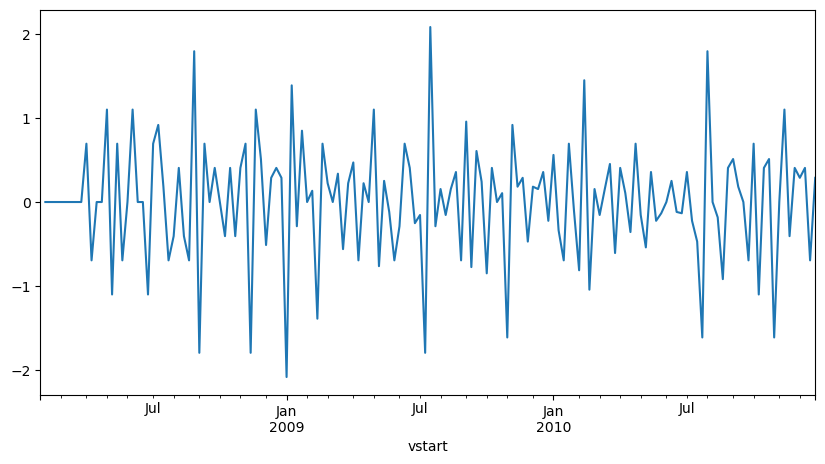

In [19]:
# First order differencing
sv_diff = svSeries.diff(1)
sv_diff.plot(figsize = (10,5))
plt.show()

Dickey-Fuller Test to confirm stationarity

In [21]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(sv_diff.dropna())

print("ADF = " + str(adf_test[0]))
print("p-value = " +str(adf_test[1]))

ADF = -8.006539673751327
p-value = 2.2597638447138472e-12


## Seasonal SARIMA Model

Above, we differenced the time series by 1 lag once to achieve stationarity, so d=1 and D=0.

In [22]:
X = svSeries.astype(np.float64)
train, test = X[:len(X)-int(0.3*len(X))], X[len(X)-int(0.3*len(X)):]

In [25]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

model = pm.auto_arima(train, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, max_P=3,
                             start_Q=0, max_Q=3,
                             seasonal=True,
                             d=1, D=0,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -82.161
Date:                Sun, 25 Jun 2023   AIC                            170.323
Time:                        13:25:33   BIC                            178.313
Sample:                    02-03-2008   HQIC                           173.561
                         - 02-14-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0207      0.005      4.245      0.000       0.011       0.030
ma.L1         -0.9302      0.048    -19.223      0.000      -1.025      -0.835
sigma2         0.2707      0.030      8.911      0.000       0.211       0.330
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                20.66
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.68
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

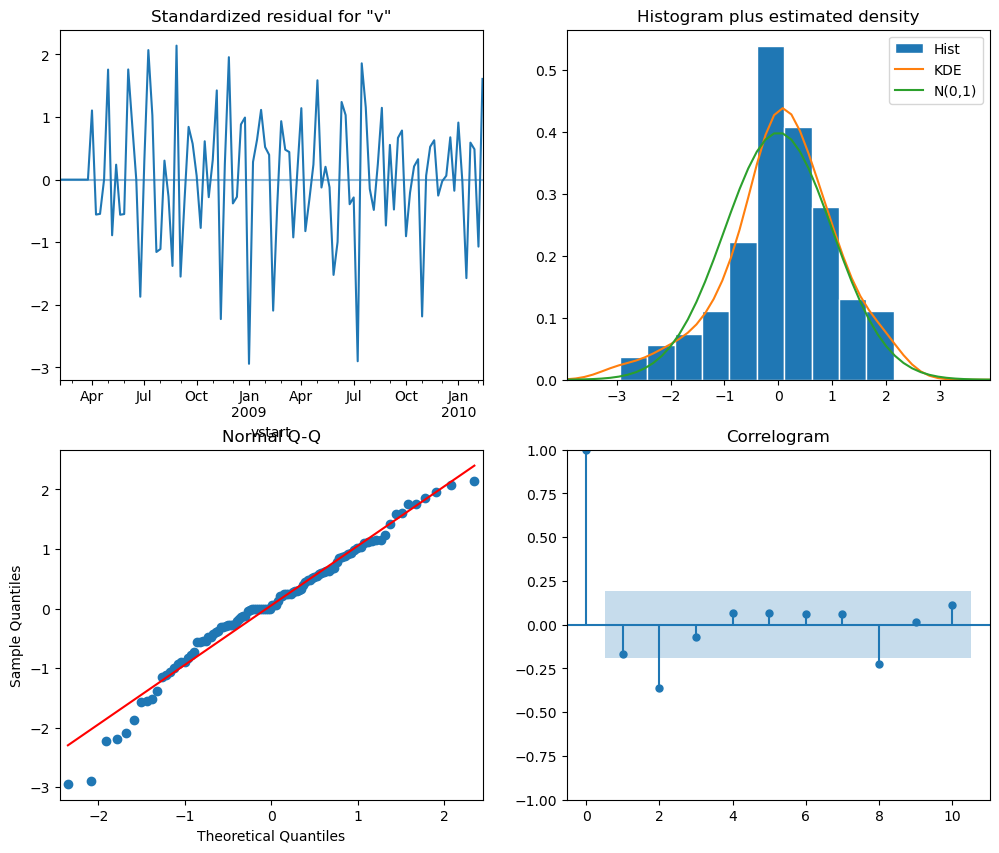

In [29]:
model = SARIMAX(train, order=(1, 1, 0), seasonal_order=(1, 0, 1, 12))
model_fitted = model.fit()
model_fitted.plot_diagnostics(figsize = (12,10))
plt.show()

In [13]:
sv_df["Seasonality"] = sv_df['Date'].map(result.seasonal)
sv_df.head(20)

,Date,Visits,Trend,Seasonality
0,2008-02-03,0.000000,NaN,0.339272
1,2008-02-10,0.000000,NaN,-0.008041
2,2008-02-17,0.000000,NaN,0.014533
3,2008-02-24,0.000000,NaN,-0.167358
4,2008-03-02,0.000000,NaN,0.021289
5,2008-03-09,0.000000,NaN,-0.060191
6,2008-03-16,0.000000,NaN,0.172101
7,2008-03-23,0.000000,NaN,0.107722
8,2008-03-30,0.000000,NaN,-0.089056
9,2008-04-06,0.693147,NaN,0.345346


In [14]:
sv_df.shape

(152, 4)

Using BOTH trend & seasonality: Training data is rows 26-110, Test is rows 110-126.

Using only seasonality: Training data is rows 0-101, Test is rows 101-152.

In [15]:
sv_train = sv_df.iloc[0:101,:]
sv_train.head()

,Date,Visits,Trend,Seasonality
0,2008-02-03,0.0,NaN,0.339272
1,2008-02-10,0.0,NaN,-0.008041
2,2008-02-17,0.0,NaN,0.014533
3,2008-02-24,0.0,NaN,-0.167358
4,2008-03-02,0.0,NaN,0.021289


In [16]:
sv_test = sv_df.iloc[101:152,:]
sv_test.tail()

,Date,Visits,Trend,Seasonality
147,2010-11-28,1.098612,NaN,-0.053690
148,2010-12-05,1.386294,NaN,-0.231371
149,2010-12-12,1.791759,NaN,-0.019810
150,2010-12-19,1.098612,NaN,0.351263
151,2010-12-26,1.386294,NaN,0.369462


## Poission Model 1: Using Seasonality Alone to Predict the Average # Visits

In [17]:
from statsmodels.discrete.count_model import GeneralizedPoisson

poisson_seas = GeneralizedPoisson(sv_train['Visits'], sv_train['Seasonality']).fit()
poisson_seas.summary()

         Current function value: nan
         Iterations: 1
         Function evaluations: 11
         Gradient evaluations: 11


C:\Users\krash\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1469: RuntimeWarning: invalid value encountered in log
  return (np.log(mu) + (endog - 1) * np.log(a2) - endog *
C:\Users\krash\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1470: RuntimeWarning: invalid value encountered in log
  np.log(a1) - gammaln(endog + 1) - a2 / a1)
C:\Users\krash\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1469: RuntimeWarning: invalid value encountered in log
  return (np.log(mu) + (endog - 1) * np.log(a2) - endog *
C:\Users\krash\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1470: RuntimeWarning: invalid value encountered in log
  np.log(a1) - gammaln(endog + 1) - a2 / a1)
C:\Users\krash\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\krash\anaconda3

<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                 Visits   No. Observations:                  101
Model:             GeneralizedPoisson   Df Residuals:                      100
Method:                           MLE   Df Model:                            0
Date:                Sun, 25 Jun 2023   Pseudo R-squ.:                     nan
Time:                        13:16:44   Log-Likelihood:                    nan
converged:                      False   LL-Null:                       -118.77
Covariance Type:            nonrobust   LLR p-value:                       nan
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Seasonality     0.4857        nan        nan        nan         nan         nan
alpha          -1.2663        nan        nan        nan         nan         nan
===============================================================================
"""

In [57]:
ppred = poisson_seas.predict(sv_test)

ValueError: shapes (48,4) and (1,) not aligned: 4 (dim 1) != 1 (dim 0)

In [52]:
pfit = poisson_seas.predict(sv_train)

The PR-Squared is 29%; LLR p-value is highly significant.

[]

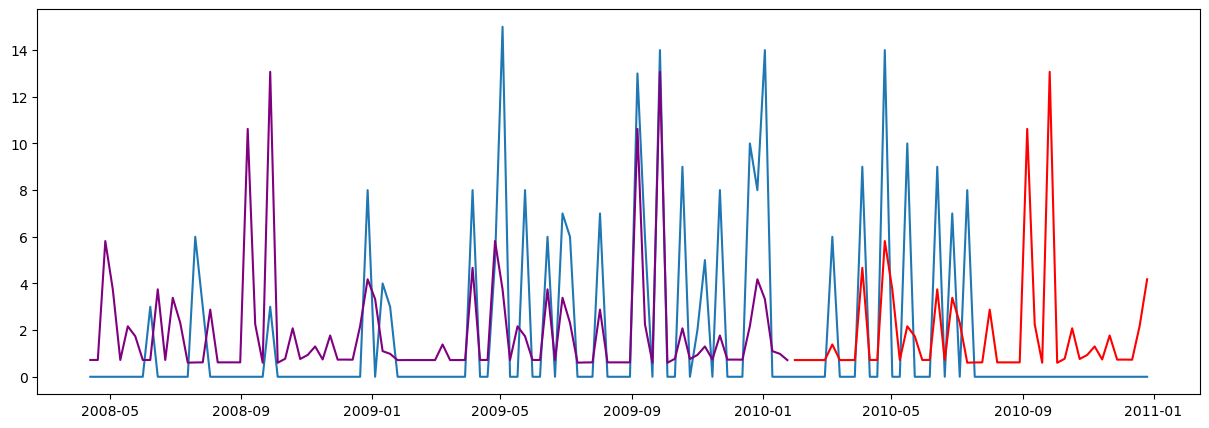

In [53]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(sv_df['Date'], sv_df['Visits'])
ax.plot(sv_test['Date'], ppred, 'r')
ax.plot(sv_train['Date'], pfit, 'purple')
ax.plot()

In [36]:
# Copied from ski-kit learn latest version because Jupyter Notebooks does not have the 
# most up-to-date-version of this code

def mape(y_true, y_pred, sample_weight=None, multioutput='uniform_average'):
   
    #y_type, y_true, y_pred, multioutput = _check_reg_targets(
    #    y_true, y_pred, multioutput)
    #check_consistent_length(y_true, y_pred, sample_weight)
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)


## Error Measures & Residual Plots: The Trend Only Model

The Training data's MAPE:

In [37]:
y_true = sv_df.iloc[26:88,1] # Visits
y_pred = pfit
mape(y_true, y_pred)

6303797044633941.0

The Training data's residuals plot:

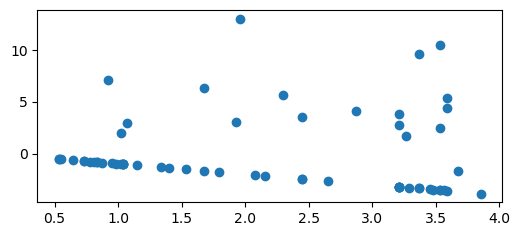

In [38]:
residual = y_true - y_pred
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

The Testing data's MAPE:

In [40]:
y_true = sv_df.iloc[88:116,1] # Visits column for test set
y_pred = ppred
mape(y_true, y_pred)

7485737195160433.0

The Testing data's residuals plot:

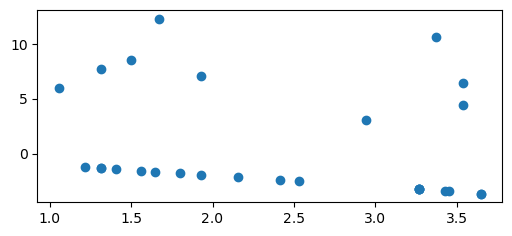

In [41]:
residual = y_true - y_pred
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

The residuals don't look randomly distributed, and the MAPEs are HUGE.

## Poisson Model 2: Using Trend and Seasonality

Let's try using both the Trend and the Seasonality to predict Average Sentinel Visits.

In [42]:
poisson_ts = poisson('Visits ~ Trend + Seasonality', data = sv_train).fit()
poisson_ts.summary()

Optimization terminated successfully.
         Current function value: 1.724945
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                 Visits   No. Observations:                   62
Model:                        Poisson   Df Residuals:                       59
Method:                           MLE   Df Model:                            2
Date:                Sat, 24 Jun 2023   Pseudo R-squ.:                  0.4993
Time:                        20:11:58   Log-Likelihood:                -106.95
converged:                       True   LL-Null:                       -213.61
Covariance Type:            nonrobust   LLR p-value:                 4.729e-47
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.9668      0.401     -2.412      0.016      -1.752      -0.181
Trend           0.5131      0.159      3.235      0.001       0.202       0.824
Seasonality     0.2460      0.019     12.896      0.000       0.209       0.283
===============================================================================
"""

In [43]:
ppred = poisson_ts.predict(sv_test)

In [44]:
pfit = poisson_ts.predict(sv_train)

[]

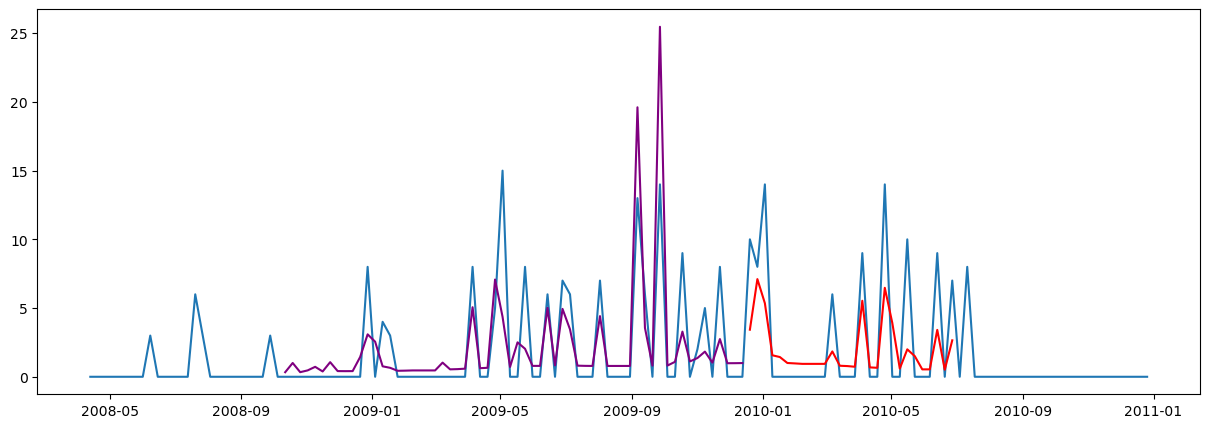

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(sv_df['Date'], sv_df['Visits'])
ax.plot(sv_test['Date'], ppred, 'r')
ax.plot(sv_train['Date'], pfit, 'purple')
ax.plot()

## Error Measures & Residual Plots: The Trend and Seasonality Model

In [58]:
y_true = sv_df.iloc[26:94,1] # Visits
y_pred = linfit
mape(y_true, y_pred)

0.44668626016363

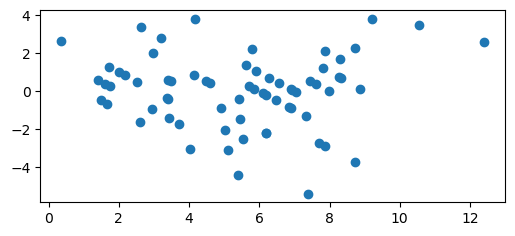

In [59]:
residual = y_true - y_pred
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

In [60]:
y_true = sv_df.iloc[94:126,1] # Visits column for test set
y_pred = linpred
mape(y_true, y_pred)

0.16983754967873402

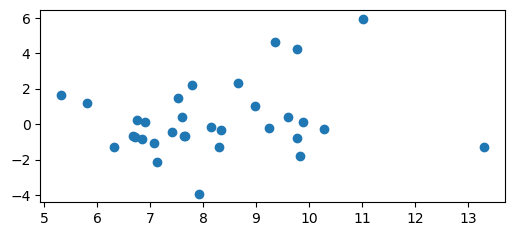

In [61]:
residual = y_true - y_pred
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

## Conclusion

Predictions were able to be drawn from this data set for both an average trend, and for it's trend and seasonality.  The model with both trend and seasonality performed much better, with MAPE in the Test data of 5.6%